### Importing atmospheric data from NREL's WindToolKit data set using ssrs.WTK module

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import griddata

In [3]:
# importing ssrs funationality used in this notebook
from ssrs import WTK, WtkSource, TurbinesUSWTB
from ssrs.utils import get_extent_from_bounds

In [4]:
# directory where output is saved
output_dir = os.path.join(os.path.abspath(os.path.curdir), 'output/')

In [5]:
# list valid WTK data sources
WTK.valid_sources

('AWS', 'EAGLE', 'EAGLE_LED')

In [6]:
# inspect available layers
wtk_source = WtkSource('AWS')
wtk_source.valid_layers

Considering WindToolKit source: AWS


['coordinates',
 'inversemoninobukhovlength_2m',
 'meta',
 'precipitationrate_0m',
 'pressure_0m',
 'pressure_100m',
 'pressure_200m',
 'relativehumidity_2m',
 'temperature_100m',
 'temperature_10m',
 'temperature_120m',
 'temperature_140m',
 'temperature_160m',
 'temperature_200m',
 'temperature_2m',
 'temperature_40m',
 'temperature_60m',
 'temperature_80m',
 'time_index',
 'winddirection_100m',
 'winddirection_10m',
 'winddirection_120m',
 'winddirection_140m',
 'winddirection_160m',
 'winddirection_200m',
 'winddirection_40m',
 'winddirection_60m',
 'winddirection_80m',
 'windspeed_100m',
 'windspeed_10m',
 'windspeed_120m',
 'windspeed_140m',
 'windspeed_160m',
 'windspeed_200m',
 'windspeed_40m',
 'windspeed_60m',
 'windspeed_80m']

In [7]:
# Initialize WTK object to download and manipulate data for given lonlat bounds
wtk_layers = ['windspeed_100m', 'winddirection_100m', 'pressure_100m','temperature_100m']
lonlat_bounds = (-106.411, 42.769, -105.1686, 43.2566)
wtk = WTK('AWS', lonlat_bounds, wtk_layers, output_dir)

Considering WindToolKit source: AWS
WTK: Downloading following layers:
temperature_100m
winddirection_100m
pressure_100m
windspeed_100m


In [8]:
# get data for various variables for a given datetime
dtime = datetime(2014, 10, 12, 9) # (year, month, date, hour)
wtkdf = wtk.get_dataframe_for_this_time(dtime)
wtkdf.head()

,Indices,Longitude,Latitude,windspeed_100m,pressure_100m,temperature_100m,winddirection_100m
0,821260,-106.430664,42.753323,6.14,77670.0,6.08,298.19
1,822319,-106.405550,42.755726,6.64,77230.0,5.75,294.23
2,822320,-106.408830,42.774178,5.71,80150.0,8.32,270.93
3,822321,-106.412110,42.792630,4.83,81950.0,9.91,268.35
4,822322,-106.415405,42.811080,4.15,82250.0,10.15,282.29


In [9]:
# get all the wind turbines in this region
lonlat_crs = 'EPSG:4326'
turbines = TurbinesUSWTB(lonlat_bounds, lonlat_crs, min_hubheight=60.)
turbines.print_details()

TurbinesUSWTB: Importing turbine data from USWTB..
Number of projects: 9
Number of turbines: 538
Hub height (min,median,max): 80.0, 80.0, 89.0
Rotor Dia (min,median,max): 77.0, 91.0, 127.0
    Project                   State Year  Count Hub_Hght  Rotor_Dia 
1.  Cedar Springs III         WY    2020  48    89.0      127.0     
2.  Cedar Springs II          WY    2020  73    89.0      127.0     
3.  Cedar Springs I           WY    2020  72    89.0      127.0     
4.  Top of the World          WY    2010  110   80.0      77.0      
5.  Rolling Hills             WY    2009  66    80.0      91.0      
6.  Glenrock III              WY    2009  26    80.0      91.0      
7.  Glenrock                  WY    2008  66    80.0      91.0      
8.  Campbell Hill             WY    2009  66    80.0      77.0      
9.  Casper Wind Farm          WY    2009  11    80.0      77.0      


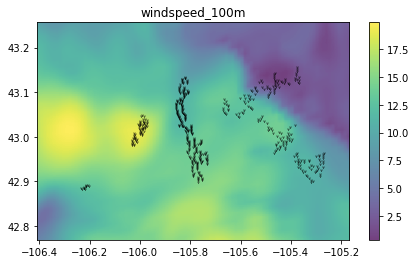

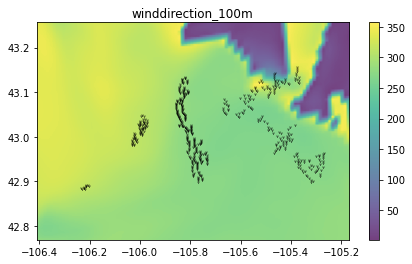

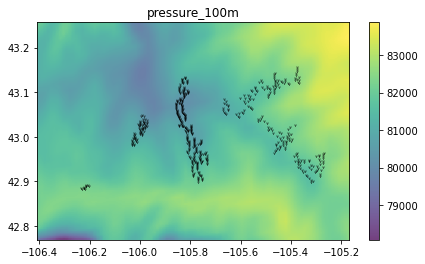

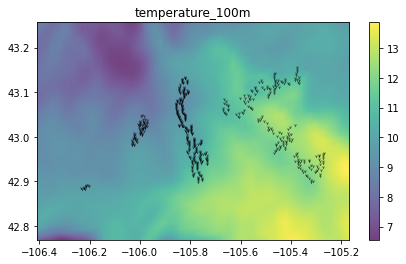

In [10]:
# Plot the downloaded atmospehric variables in lon/lat crs
interp_type = 'linear' # nearest, linear, cubic
xname ='Longitude'
yname = 'Latitude'
num_pts = 100
turb_xlocs, turb_ylocs = turbines.get_locations()
for j, this_var in enumerate(wtk_layers):
    fig, ax = plt.subplots(figsize=(7,4))
    vardata = wtkdf.loc[:, this_var].values.flatten()
    xlocs, ylocs = wtk.get_coordinates()
    extent = get_extent_from_bounds(lonlat_bounds)
    xmin, xmax, ymin, ymax = extent
    xmesh, ymesh = np.meshgrid(np.linspace(xmin,xmax,num_pts), np.linspace(ymin,ymax,num_pts))
    vargriddata = griddata(np.array([xlocs, ylocs]).T, vardata, (xmesh, ymesh), method=interp_type)
    cm = ax.imshow(vargriddata, cmap='viridis', origin='lower', extent=extent, alpha=0.75, aspect='auto')
    #ax.plot(wtkdf[xname], wtkdf[yname], '.k', alpha=0.15, markersize=3.)
    ax.plot(turb_xlocs, turb_ylocs, '1k', alpha=0.5, markersize=3.)
    ax.set_title(this_var)
    fig.colorbar(cm, ax = ax)